In [1]:
from config import *
from map_wrapper import *

In [2]:
print(f'{year}年{month}月')

2020年2月


In [3]:
import pandas as pd
import sys
sys.path.append('../../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [4]:
conn=db.get_conn()
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and monthly_salary<80000", con=conn)
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']




In [5]:

join_counts=[conn.execute(f"select COUNT(1) from _{year}{month:02}").fetchall()[0][0]]
percents=[]
for i in range(1,month-6+1):
    sql=f"select COUNT(1) from _{year}{month:02} a join _{year}{month-i:02} b on a.job_id = b.job_id"
    #print(sql)
    count=conn.execute(sql).fetchall()[0][0]

    join_counts.append(count)
    subtract = join_counts[i-1]-join_counts[i]
    percents.append(subtract*1.0/join_counts[i])

percents.append(join_counts[-1]/join_counts[0])

In [6]:
join_counts

[75336]

In [7]:
percents

[1.0]

ValueError: 'label' must be of length 'x'

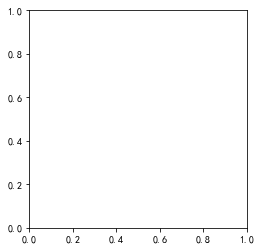

In [9]:
plt.pie(percents, labels=['1','2','3','4','5','6','7','7+'])
plt.show()

In [ ]:
data.shape[0]

In [ ]:
conn.close()

In [ ]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

data_format={"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}"}



In [ ]:
data_career=get_sub_stats_by_col(data,'career')
data_career.style.format(data_format)

# 程序员工资

In [ ]:
data_city=get_sub_stats_by_col(data,'province')
#data_city.city=data_city.city.map(translate_dict)
data_city.style.hide_index().format(data_format)

In [ ]:
describe(data_city,'程序员')

In [ ]:
draw_province_map(data_city,2000,'2019年5月中国大陆各省程序员工资')

# 算法工程师

In [ ]:
describe(get_sub_stats_by_col(data[data.career=='算法工程师'],'province'), '算法工程师')

In [ ]:
data_city_algorithm=get_sub_stats_by_col(data[data.career=='算法工程师'],'province')

data_city_algorithm.style.hide_index().format(data_format)

In [ ]:
describe(data_city_algorithm,'算法工程师')

In [ ]:
draw_province_map(data_city_algorithm,100,f'2019年{month}月中国大陆各省算法工程师工资')

# 系统架构师

In [ ]:
data_city_architect=get_sub_stats_by_col(data[data.career=='系统架构师'],'province')

data_city_architect.style.hide_index().format(data_format)

In [ ]:
describe(data_city_architect,'系统架构师')

In [ ]:
draw_province_map(data_city_architect,40,f'2019年{month}月中国大陆各省【架构师】工资')

# 生物信息工程师

In [ ]:
data_bio=get_sub_stats_by_col(data[data.career=='生物信息工程师'],'province')
#data_bio.city=data_bio.city.map(translate_dict)
data_bio.style.hide_index().format(data_format)

In [ ]:
describe(data_bio,'生物信息工程师')

In [ ]:
draw_province_map(data_bio,2,'2019年4月中国大陆各省【生物信息工程师】工资')

# 爬虫工程师

In [ ]:
data_spider=get_sub_stats_by_col(data[data.career=='爬虫工程师'],'province')


data_spider=data_spider[data_spider.head_count>10]
data_spider.style.hide_index().format(data_format)

In [ ]:
describe(data_spider, '爬虫工程师')

In [ ]:
draw_province_map(data_spider,5,f'2019年{month}月中国大陆各省【爬虫工程师】工资')

# Java程序员

In [ ]:
data_java=get_sub_stats_by_col(data[(data.pl_java==1)],'province')
data_java.style.hide_index().format(data_format)

In [ ]:
describe(data_java, 'Java程序员')

In [ ]:
draw_province_map(data_java, 500, f'2019年{month}月中国大陆各省【Java工程师】工资')

# Python程序员

In [ ]:
data_python=get_sub_stats_by_col(data[(data.pl_python==1)],'province')
data_python.style.hide_index().format(data_format)

In [ ]:
#describe(data_python, 'Python程序员')

In [ ]:
draw_province_map(data_python, 100,  f'{year}年{month}月中国大陆各省【Python工程师】工资')